In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest

```
id       = case number
futime   = number of days between registration and the earlier of death,
           transplantion, or study analysis time in July, 1986
status   = 0=alive, 1=liver transplant, 2=dead
drug     = 1= D-penicillamine, 2=placebo
age      = age in days
sex      = 0=male, 1=female
ascites  = presence of ascites: 0=no 1=yes
hepato   = presence of hepatomegaly 0=no 1=yes
spiders  = presence of spiders 0=no 1=yes
edema    = presence of edema 0=no edema and no diuretic therapy for edema;
          .5 = edema present without diuretics, or edema resolved by diuretics;
           1 = edema despite diuretic therapy
bili     = serum bilirubin in mg/dl
chol     = serum cholesterol in mg/dl
albumin  = albumin in gm/dl
copper   = urine copper in ug/day
alk_phos = alkaline phosphatase in U/liter
sgot     = SGOT in U/ml
trig     = triglicerides in mg/dl
platelet = platelets per cubic ml/1000
protime  = prothrombin time in seconds
stage    = histologic stage of disease
```

In [6]:
columns = ["id", "futime", "status", "drug", "age", "sex",
           "ascites", "hepato", "spiders", "edema", "bili",
           "chol", "albumin", "copper", "alk_phos", "sgot",
           "trig", "platelet", "protime", "stage"]
df = pd.read_fwf("data/pbc.dat", header=None, names=columns, na_values=["."], index_col="id")
df["futime"] = df["futime"]/365.25

df = df.dropna(axis=0,how='any')

df = df[df["status"] != 1]


Xs = df.loc[:, ~df.columns.isin(["futime","status"])]

ys = np.zeros(len(Xs), dtype=np.dtype([('event', '?'), ('time', '<f8')]))
# true if event happened at that time
ys['event'] = df["status"] == 2
ys['time'] = df['futime']

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.25, random_state=0)

rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=0)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=0)

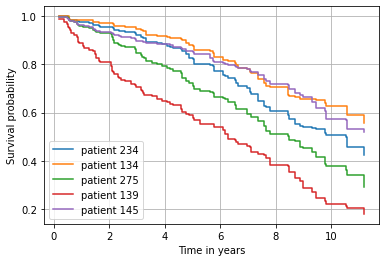

In [7]:
rsf.score(X_test,y_test)

Xplot = X_test[:5]
yplot = y_test[:5]

for i, survfunc in enumerate(rsf.predict_survival_function(Xplot, return_array=True)):
    plt.step(rsf.event_times_, survfunc, where="post", label=f"patient {Xplot.iloc[i].name}")
plt.xlabel("Time in years")
plt.ylabel("Survival probability")
plt.legend()
plt.grid(True)

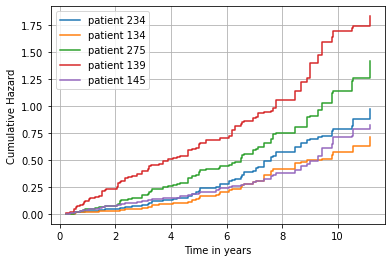

In [8]:
for i, survfunc in enumerate(rsf.predict_cumulative_hazard_function(Xplot, return_array=True)):
    plt.step(rsf.event_times_, survfunc, where="post", label=f"patient {Xplot.iloc[i].name}")
plt.xlabel("Time in years")
plt.ylabel("Cumulative Hazard")
plt.legend()
plt.grid(True)

In [10]:
print("Risk scores")
print("-----------")
risks = [rsf.predict(Xplot.iloc[[i]])[0] for i in range(len(Xplot))]
index = [Xplot.iloc[i].name for i in range(len(Xplot))]
print(pd.Series(data=risks, index=index))


Risk scores
-----------
234    19.130465
134    13.705452
275    28.947763
139    47.702996
145    16.518798
dtype: float64
